In [55]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets
from torchvision import transforms
 

dict_keys(['in_channels', 'size', 'classes', 'epochs', 'batch_size', 'lr', 'device', 'folder', 'population_size', 'generations', 'depths', 'filters', 'kernel_sizes', 'final_epochs', 'time', 'best_cromosome', 'generations_list', 'val_accuracy_list'])


Best cromosome: [3, 64, 3, 64, 3, 32, 3]
Number of curves: 12


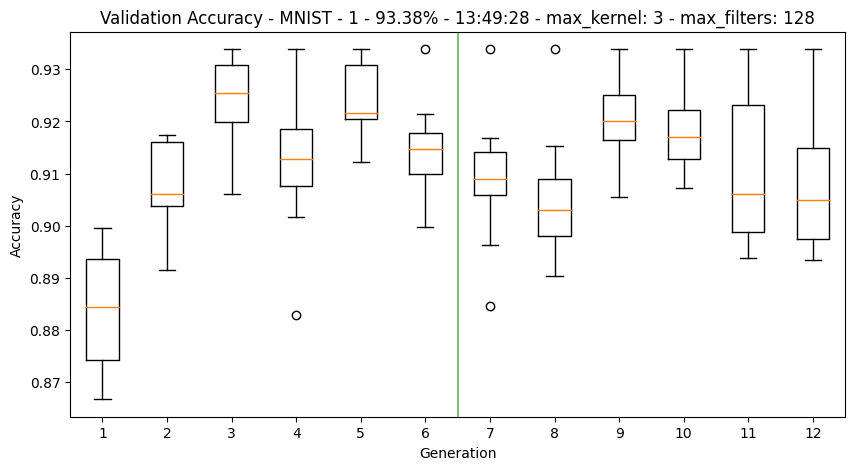

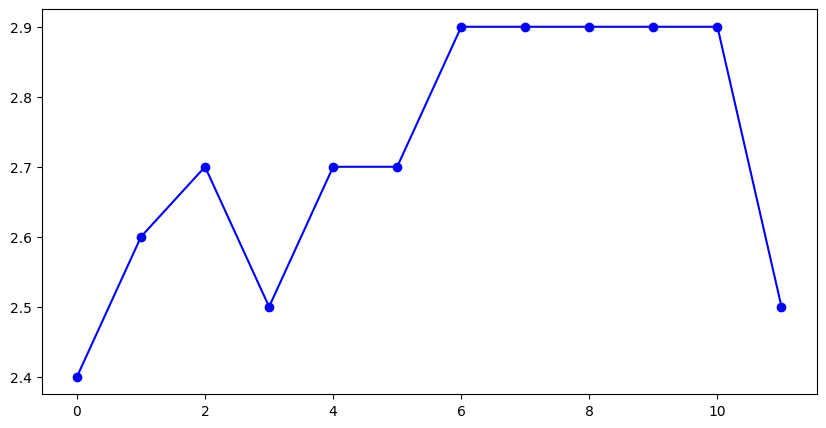

Best cromosome: [3, 16, 3, 128, 3, 128, 3]
Number of curves: 12


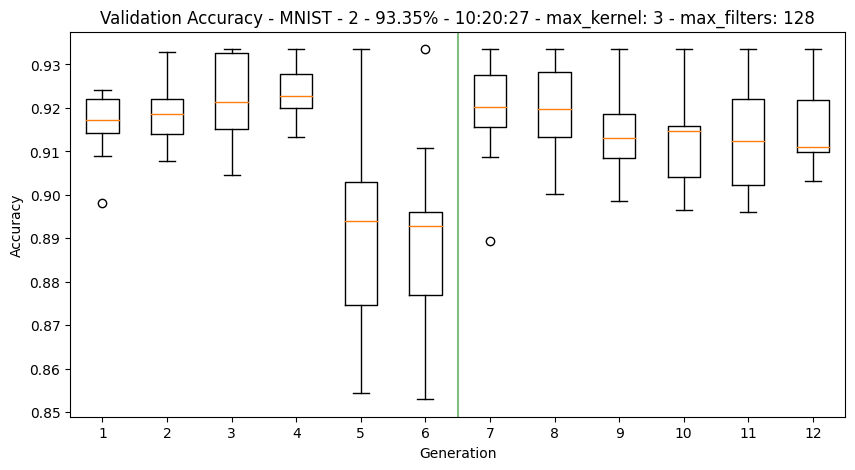

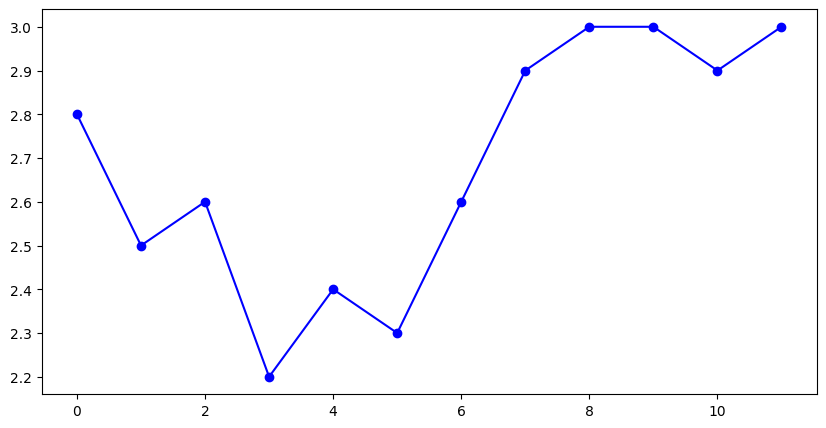

Best cromosome: [7, 32, 3, 64, 3, 128, 7, 16, 3, 64, 7, 64, 7, 64, 5]
Number of curves: 12


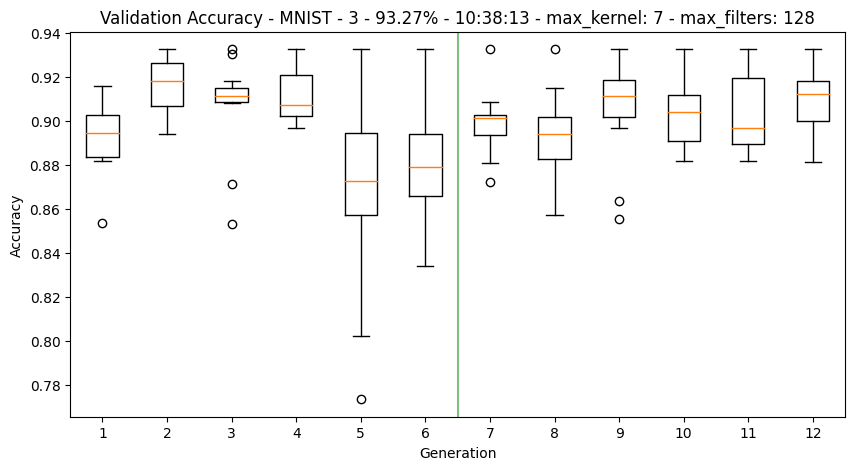

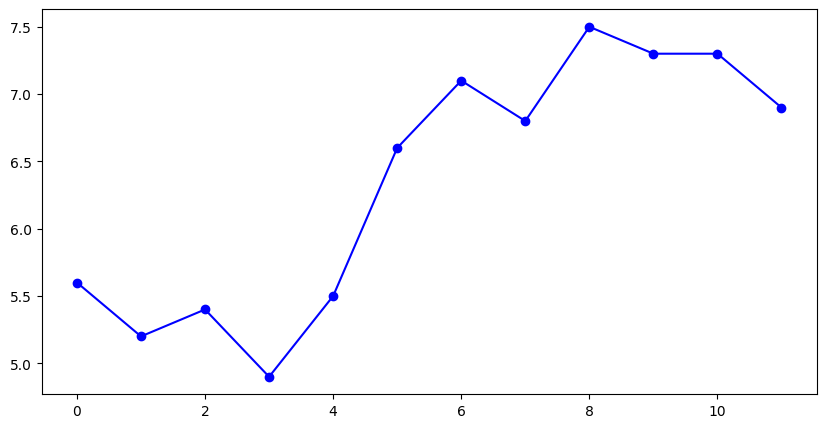

Best cromosome: [8, 128, 3, 64, 7, 64, 5, 64, 3, 8, 3, 4, 7, 8, 3, 16, 3]
Number of curves: 12


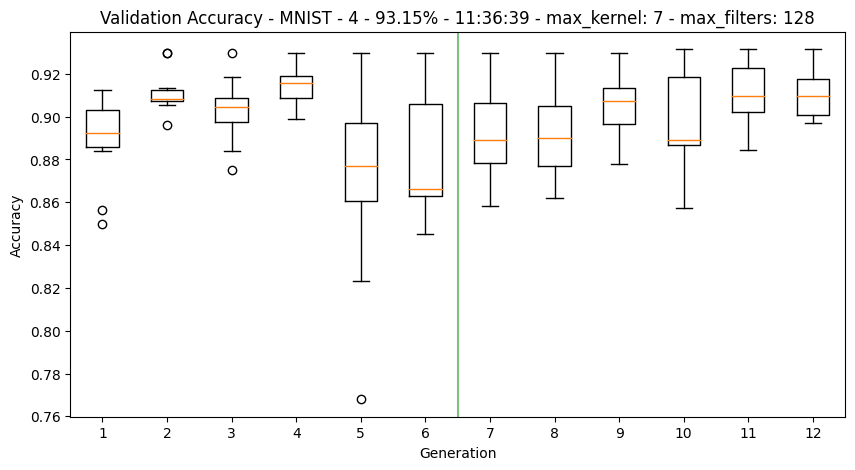

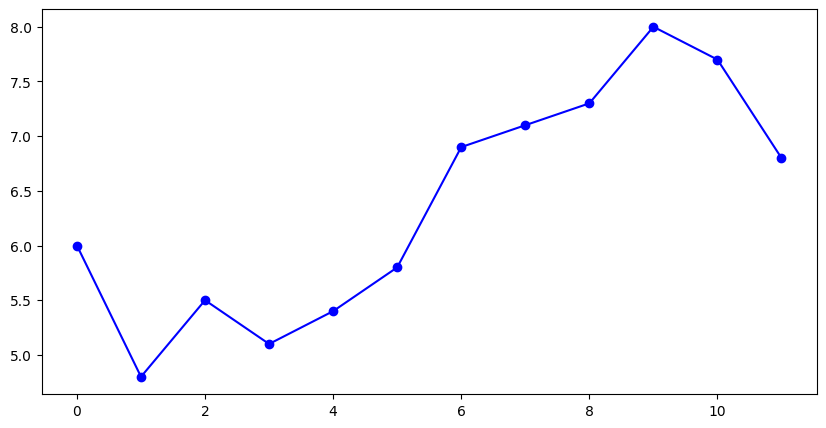

Best cromosome: [8, 32, 3, 16, 7, 8, 3, 32, 5, 8, 5, 32, 7, 8, 5, 128, 3]
Number of curves: 12


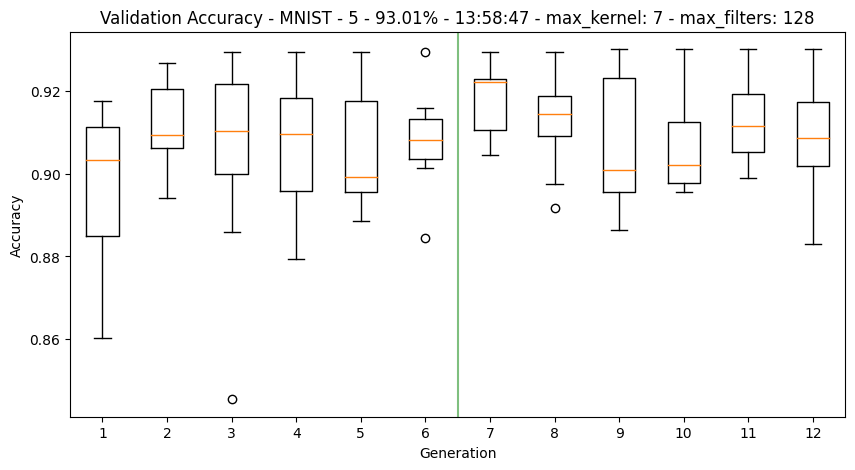

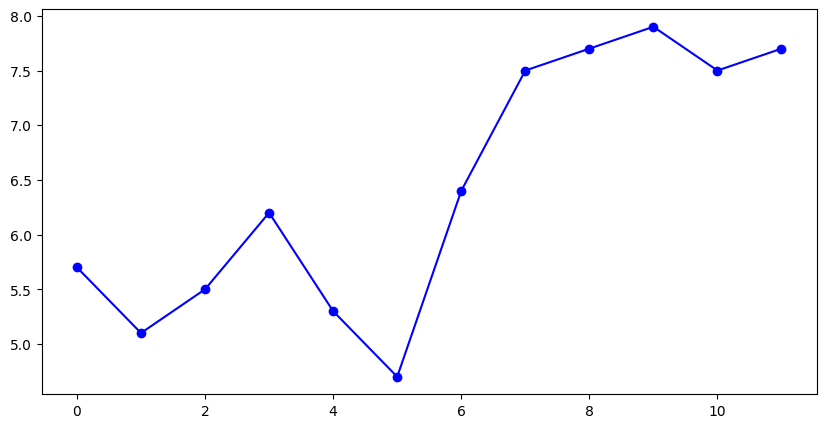

Best cromosome: [8, 128, 3, 16, 5, 64, 5, 64, 7, 16, 3, 128, 3, 8, 3, 64, 3]
Number of curves: 12


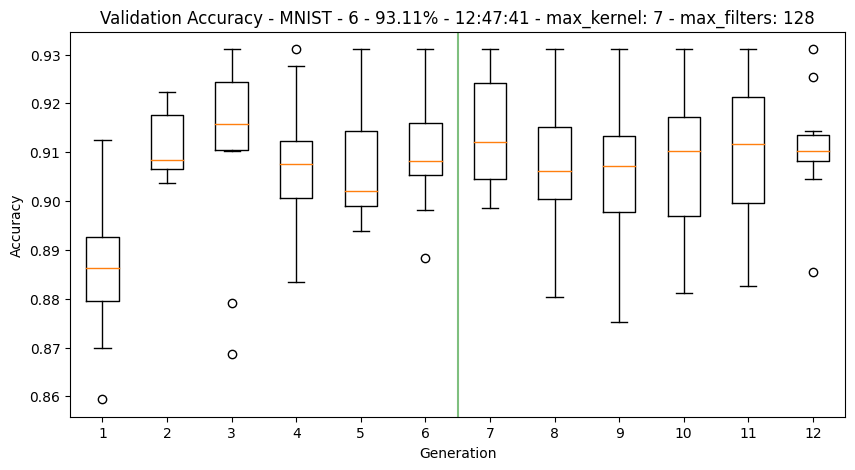

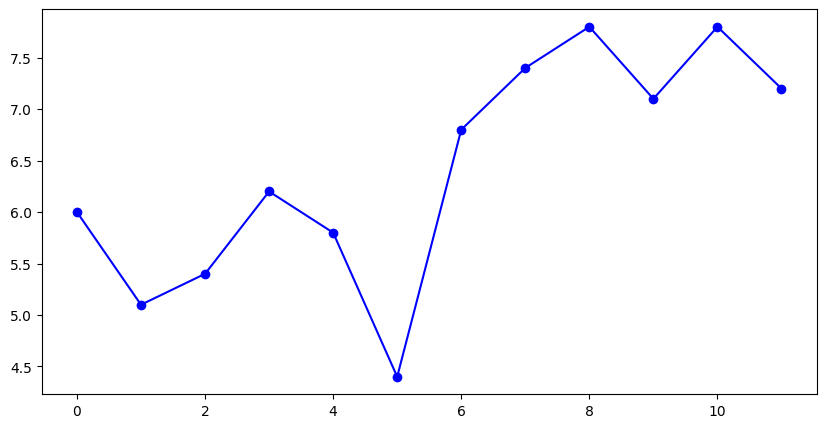

In [151]:
# Incializar boxplot_data
boxplot_data = np.array([])
time_data = np.array([])
for i in range(6):
    params = np.load(f"models/mnist/model_params_{i}.npy", allow_pickle=True).item()
    print(f"Best cromosome: {params['best_cromosome']}")
    print(f"Number of curves: {len(params['val_accuracy_list'])}")
    time_data = np.append(time_data, params['time'])
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    
    # Curva con el mejor accuracy
    max_acc = np.max(params['val_accuracy_list'], axis=1)
    for j in range(1, len(max_acc)): 
        if max_acc[j] < max_acc[j-1]: max_acc[j] = max_acc[j-1]
    
    # Graficar curva maxima de accuracy
    acc_list = np.array(params['val_accuracy_list']).T
    acc_list = np.vstack((acc_list, max_acc))
    
    # Graficar boxplot
    ax.boxplot(acc_list, showfliers=True)
    # tiempo en hh:mm:ss
    ax.set_title(f"Validation Accuracy - MNIST - {i+1} - {100*np.max(params['val_accuracy_list']):.2f}% - {time.strftime('%H:%M:%S', time.gmtime(params['time']))} - max_kernel: {max(params['kernel_sizes'])} - max_filters: {max(params['filters'])}")
    # Linea horizontal verde en la mitad del grafico
    ax.axvline(x=len(params['val_accuracy_list'])/2+0.5, color='green', alpha=0.5)
    ax.set_xlabel("Generation")
    ax.set_ylabel("Accuracy")
    # Ticks para el eje x
    ax.set_xticks(np.arange(1, 13))
    plt.show()
    # Graficar profundidad promedio por generacion, cantidad de kernels y cantidad de filtros
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    mean_depth = []
    for generation in params['generations_list']:
        mean_depth.append(np.mean([cromosome[0] for cromosome in generation]))
    ax.plot(mean_depth, color='blue', alpha=1, marker='o')
    plt.show()
    # Boxplot
    if i == 0:
        boxplot_data = max_acc
    boxplot_data = np.vstack((boxplot_data, max_acc))
    
    
     

In [154]:
# Tiempo promedio
print(f"Tiempo promedio hh:mm:ss: {time.strftime('%H:%M:%S', time.gmtime(np.mean(time_data)))}, Cantidad de experimentos = {len(time_data)}")

Tiempo promedio hh:mm:ss: 12:11:53, N=6


Text(0.5, 0, 'Generación')

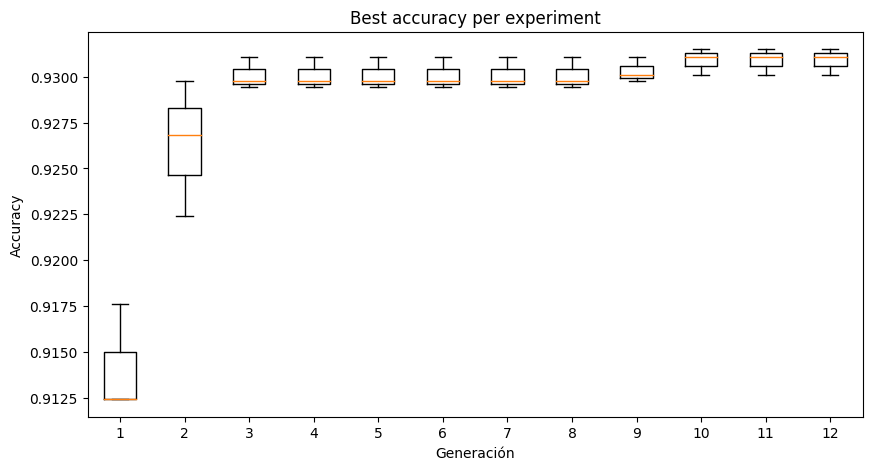

In [145]:
# Graficar boxplot
fig, ax = plt.subplots(1,1, figsize=(10,5))
# Boxplot con los ultimos 3 filas
ax.boxplot(boxplot_data[-3:,:])
ax.set_ylabel("Accuracy")
# Titulo al boxplot de los mejores por experimento
ax.set_title("Best accuracy per experiment - MNIST")
# eje x title
ax.set_xlabel("Generación")

Number of curves: 12


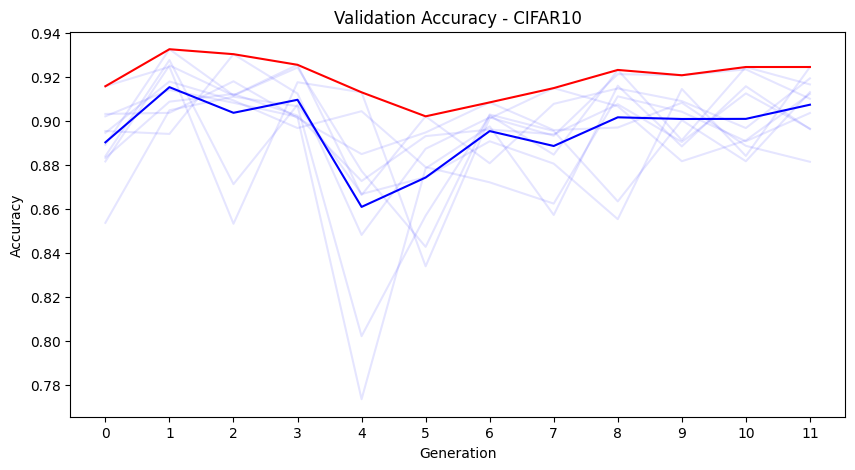

In [81]:
params = np.load(f"models/mnist/model_params_2.npy", allow_pickle=True).item()
fig, ax = plt.subplots(1,1, figsize=(10,5))
# Agregar todos los valores de accuracy en el axis 1 (darle transpuesta)
for acc in np.array(params['val_accuracy_list']).T:
    ax.plot(acc, color='blue', alpha=0.1)
# Agregar la media
ax.plot(np.mean(params['val_accuracy_list'], axis=1), color='blue', alpha=1, label ='mean')
# Curva con el mejor accuracy
ax.plot(np.max(params['val_accuracy_list'], axis=1), color='red', alpha=1, label='max')
ax.set_title("Validation Accuracy - CIFAR10")
ax.set_xlabel("Generation")
ax.set_ylabel("Accuracy")
# Ticks para todos los valores
ax.set_xticks(np.arange(0, 12))
# Print de la cantidad de curvas
print(f"Number of curves: {len(params['val_accuracy_list'])}")
plt.show()